In [1]:
!pip install openai

     |████████████████████████████████| 44 kB 2.4 MB/s eta 0:00:011
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
     |████████████████████████████████| 12.2 MB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 242 kB 97.1 MB/s eta 0:00:01
     |████████████████████████████████| 146 kB 96.8 MB/s eta 0:00:01
  Created wheel for openai: filename=openai-0.25.0-py3-none-any.whl size=55859 sha256=90e0d5861040bd260e279fb9f50e3e3e70971b02bc74152bb606a559ca576628
  Stored in directory: /home/azureuser/.cache/pip/wheels/4b/92/33/6f57c7aae0b16875267999a50570e81f15eecec577ebe05a2e
Successfully built openai
ERROR: pyldavis 3.3.1 requires sklearn, which is not installed.
ERROR: pandas-ml 0.6.1 requires enum34, which is not installed.
ERROR: fbprophet 0.7.1 requires cmdstanpy==0.9.5, which is not installed.
ERROR: rliable 1.0.8 has requirement scipy>=1.7.0, but you'll have scipy 1.5.3

In [ ]:
from azureml.core import Workspace
ws = Workspace.from_config()
keyvault = ws.get_default_keyvault()
keyvault.get_secret(name="secret-name")

# Summarization

In [2]:
#Note: The openai-python library support for Azure OpenAI is in preview.
import os
import openai
openai.api_type = "azure"
openai.api_base = "https://solliance-openai-01.openai.azure.com/"
openai.api_version = "2022-06-01-preview"
openai.api_key = # replace with key from key vault

In [108]:
response = openai.Completion.create(
  engine="gpt3-text-ada-001",
  prompt="A neutron star is the collapsed core of a massive supergiant star, which had a total mass of between 10 and 25 solar masses, possibly more if the star was especially metal-rich.[1] Neutron stars are the smallest and densest stellar objects, excluding black holes and hypothetical white holes, quark stars, and strange stars.[2] Neutron stars have a radius on the order of 10 kilometres (6.2 mi) and a mass of about 1.4 solar masses.[3] They result from the supernova explosion of a massive star, combined with gravitational collapse, that compresses the core past white dwarf star density to that of atomic nuclei.\n\nTl;dr",
  temperature=0.7,
  max_tokens=60,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0,
  stop=None
)

In [112]:
response.choices[0].text

'\n\nA neutron star is the collapsed core of a massive supergiant star, which had a total mass of between 10 and 25 solar masses.'

# Introducing Embeddings

In the following try entering any text as input (be careful to exclude new line characters) and observe the embedding that results.

In [26]:
response = openai.Embedding.create(
  engine="gpt3-similarity-babbage-001",
  input="A neutron star is the collapsed core of a massive supergiant star."
)

In [37]:
response.data[0].embedding

[0.012890788726508617,
 0.01312282308936119,
 -0.006028592120856047,
 -0.000760019407607615,
 0.022240908816456795,
 0.018734613433480263,
 -0.01254703477025032,
 -0.005061783362179995,
 0.009289962239563465,
 -0.016311144456267357,
 -0.011825150810182095,
 -0.005521554499864578,
 0.006411019247025251,
 0.015443164855241776,
 -0.008954801596701145,
 0.006961026228964329,
 -0.01675802655518055,
 -0.007296186406165361,
 0.021175269037485123,
 0.03179727867245674,
 0.1388767659664154,
 0.014557997696101665,
 0.011550147086381912,
 0.015116598457098007,
 -0.002012037206441164,
 -0.05104752257466316,
 -0.06342267990112305,
 0.022722164168953896,
 -0.04891624674201012,
 0.03530357405543327,
 0.0025781576987355947,
 -0.005568820983171463,
 -0.0013062666403129697,
 -0.009556371718645096,
 -0.001045765238814056,
 -0.004140091594308615,
 0.026967531070113182,
 -0.035544201731681824,
 0.01949087344110012,
 -0.02316904440522194,
 -0.020023692399263382,
 0.012031403370201588,
 0.04276304319500923,


## Using Embeddings to cluster "similar" text and derive insights

The following cell downloads a sample dataset that has already had the embeddings processed with the `text-similarity-babbage` model, similar to how you called it in the previous cell.  

In [9]:
import pandas as pd
import numpy as np

# for convenience, we precomputed the embeddings
datafile_path = "https://cdn.openai.com/API/examples/data/fine_food_reviews_with_embeddings_1k.csv"  
df = pd.read_csv(datafile_path)
df["babbage_similarity"] = df.babbage_similarity.apply(eval).apply(np.array)
matrix = np.vstack(df.babbage_similarity.values)
matrix.shape


(1000, 2048)

In [11]:
df.head(5)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,babbage_similarity,babbage_search
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,51,"[-0.01274053193628788, 0.010849879123270512, -...","[-0.01880764216184616, 0.019457539543509483, -..."
1,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,35,"[-0.024154752492904663, 0.0024838377721607685,...","[-0.03571609780192375, 0.010356518439948559, -..."
2,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....",277,"[0.0032693513203412294, 0.017815979197621346, ...","[-0.010433986783027649, 0.024620095267891884, ..."
3,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...,246,"[-0.03584608808159828, 0.03424076735973358, -0...","[-0.040209852159023285, 0.03804996609687805, -..."
4,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,87,"[0.005218076519668102, 0.018165964633226395, -...","[0.010450801812112331, 0.022801749408245087, -..."


In [12]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()

Cluster
2    2.601732
0    4.272059
1    4.734783
3    4.828784
Name: Score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

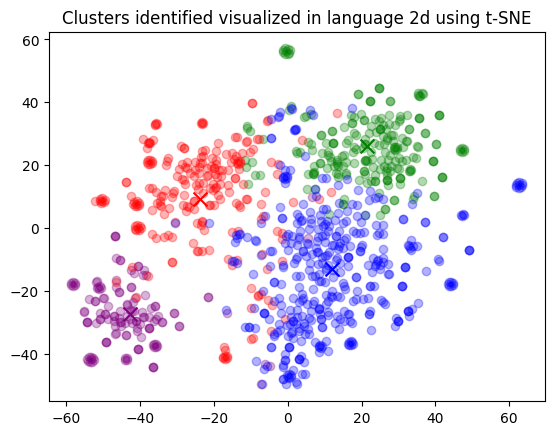

In [22]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

In [23]:
# Reading a review which belong to each group.
rev_per_cluster = 3

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="gpt3-text-davinci-002",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)

Cluster 0 Theme: The reviews all discuss different products, but they all have one thing in common: the reviewer is happy with their purchase.
5, Licorice Scottie Dogs, Red:   I love the Gimbals Red Licorice Scottie dogs I purchased from Candy Cr
5, These are excellent and excellent $$$$ here at Amazon:   This Old Dawg [Chihuahua] has been eating these for years [Bacon Strip
4, It's not Mother's milk, but it's great formula!:   After going back to work full-time, I really struggled with keeping up
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: All three customer reviews are positive and recommend the product to others.
5, Morning Coffee:   Great coffee at a good price. I'm a subscription buyer and I buy this 
5, My Favorite Coffee!:   I liked the idea of less plastic with my K-Cup, and got the added bonu
5, Celestial Iced Black Tea:   This is my favorite brand of black iced tea. I have tried others and t
-----------

## Searching with embeddings

Get the embedding for the search text. It's important to understand that for search, we use a different approach to computing the embeddings and resolving matches. 

- Query: For our search text, we need to use a *query* model (e.g., `text-search-babbage-query-001`)
- Documents: For the documents we want to search against, these embeddings need to be calculated with a *doc* model (e.g., `text-search-babbage-doc-001`)

These are two different engines in the parlance of Azure OpenAI.

In [75]:
from openai.embeddings_utils import get_embedding, cosine_similarity

Let's calculate the document embeddings for our corpus of documents that we can search against.

We'll start with getting the embedding for one document from our corpus so we can examine its shape. 

In [93]:
response = openai.Embedding.create(
  engine="gpt3-search-babbage-doc-001",
  input=df.head(1)['Text'][0]
)

doc_text_embedding = response.data[0].embedding

The embeddding of the doc has the following dimensions (run the cell to find out):

In [94]:
len(doc_text_embedding)

2048

So the document is embedded with 2,048 dimensions when using Babbage.

Now, get the embedding for each document in our corpus and store that value in the `babbage_search_2` field that we add to the dataframe.

NOTE: This will take about 2-3 minutes.

In [73]:
df["babbage_search_2"] = df.Text.apply(lambda x: get_embedding(x, engine="gpt3-search-babbage-doc-001"))


Next, recall that when you search you have to get the embedding of your search text using the `query` model. 

Let's start by getting the embedding for a search query and examine how many dimensions it has.

In [99]:
response = openai.Embedding.create(
  engine="gpt3-search-babbage-query-001",
  input="great beans" #try other inputs like "bad taste", "spoilt" or "pet food"
)

search_text_embedding = response.data[0].embedding

As before, the length of the array tells us the number of dimensions used by this embedding.

In [96]:
len(search_text_embedding)

2048

Did you notice something interesting in comparing the number of dimensions between the query and the doc? 

Yes, that's right! They have the same dimensions, even though one is a short text string and another is a long document. In fact, for search to work, they MUST have the same dimensions. 

NOTE: This explains why we couldn't use the pre-computed embedding in the `babbage_search` field of the sample data file. If you run the following cell you'll see that this one has dimensions that do not match the query. If you were to try to compute the cosine distance with these, you would get an error.

In [69]:
len(df.head(1)['babbage_search'][0])

45758

Ok, now we get to the fun part. Let's compute just how close our query is to the first doc in the sample data set. 

In [100]:
cosine_similarity(df.head(1)['babbage_search_2'][0], search_text_embedding)

0.5707751521801852

The `cosine_similarity` function returns a value between `0.0` and `1.0` where the closer the value is to `1.0` the more similar the two.

Run the next cell to compute the similarity between the query and the doc, for each doc in the dataset. We'll sort the data by the similarities score so that higher scores appear first and then we can pick the top N to see the best results.

In [101]:
df["similarities"] = df.babbage_search_2.apply(lambda x: cosine_similarity(x, search_text_embedding))

Lets take a look at the top 3 closest results.

In [102]:
pd.set_option('display.max_colwidth', 320)
pd.set_option('display.max_rows', None)

df.sort_values("similarities", ascending=False).head(n=3)[['Text', 'similarities']]

,Text,similarities
812,"This is to me a great coffee, once you try it you will enjoy it, this coffee has a wonderful taste.",0.733524
208,Great coffee! Love all Green Mountain coffee and all the wonderful flavors. Would and do recommend this coffee to all my friends.,0.701117
202,Great coffee! Love all Green Mountain coffee and all the wonderful flavors. Would and do recommend this coffee to all my friends.,0.701117


Do the above results appear like a good match for your search query?